# Neighbourhood Geodemographics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [2]:
oac = pd.read_csv('csv/2011oac.csv')
conversion_chart = pd.read_csv('csv/pcd2oa.csv')
portraits = pd.read_csv('csv/penportraits.csv')

/home/peterprescott/miniconda3/envs/babel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Neighbourhood Classifications

In [3]:
def geodem(postcode):
    """Get geodemographic classification for given postcode."""
    
    # first get output area of postcode
    try:
        output_area = conversion_chart.loc[conversion_chart.PCD7==postcode].OA11CD.values[0]
    except:
        output_area = 'Not Found'
    
    # then get classification of output area
    try:
        classification = oac.loc[oac['Output Area Code']==output_area]['Subgroup Code'].values[0]
    except:
        classification = 'Not Found'
    
    # also get relevant supergroup/group/subgroup pen portraits
    try:
        supergroup = portraits.loc[portraits.Code==classification[0]]
        group = portraits.loc[portraits.Code==classification[:2]]
        subgroup = portraits.loc[portraits.Code==classification]

        supergroup_description = supergroup.Description.values[0]
        group_description = group.Description.values[0]
        subgroup_description = subgroup.Description.values[0]
        
        supergroup = supergroup.Name.values[0]
        group = group.Name.values[0]
        subgroup = subgroup.Name.values[0]

    except:
        supergroup = group = subgroup = supergroup_description = group_description = subgroup_description = 'Not Found'
    
    
    return {'classification':classification,
            'supergroup':supergroup,
            'group':group,
            'subgroup':subgroup,
            'supergroup-description': supergroup_description,
            'group-description': group_description,
            'subgroup-description': subgroup_description
           }

In [4]:
churches = ['mossleyhill','sthelens','gateway','stoneycroftsalvationarmy']

In [5]:
data = {}
for church in churches:
    data[church] = pd.read_csv(f'sensitive/postcodes/{church}.csv')
    

In [6]:
for church in churches:
    data[church] = pd.merge(data[church],conversion_chart[['OA11CD','PCD7']],left_on='Postcode',right_on='PCD7')
    data[church].drop(columns='PCD7',inplace=True)
    gd = {}
    for postcode in data[church]['Postcode']:
        gd[postcode] = geodem(postcode)
    data[church]['Supergroup'] = data[church]['Postcode'].apply(lambda postcode: gd[postcode]['supergroup'])
    data[church]['Group'] = data[church]['Postcode'].apply(lambda postcode: gd[postcode]['group'])
    data[church]['Subgroup'] = data[church]['Postcode'].apply(lambda postcode: gd[postcode]['subgroup'])

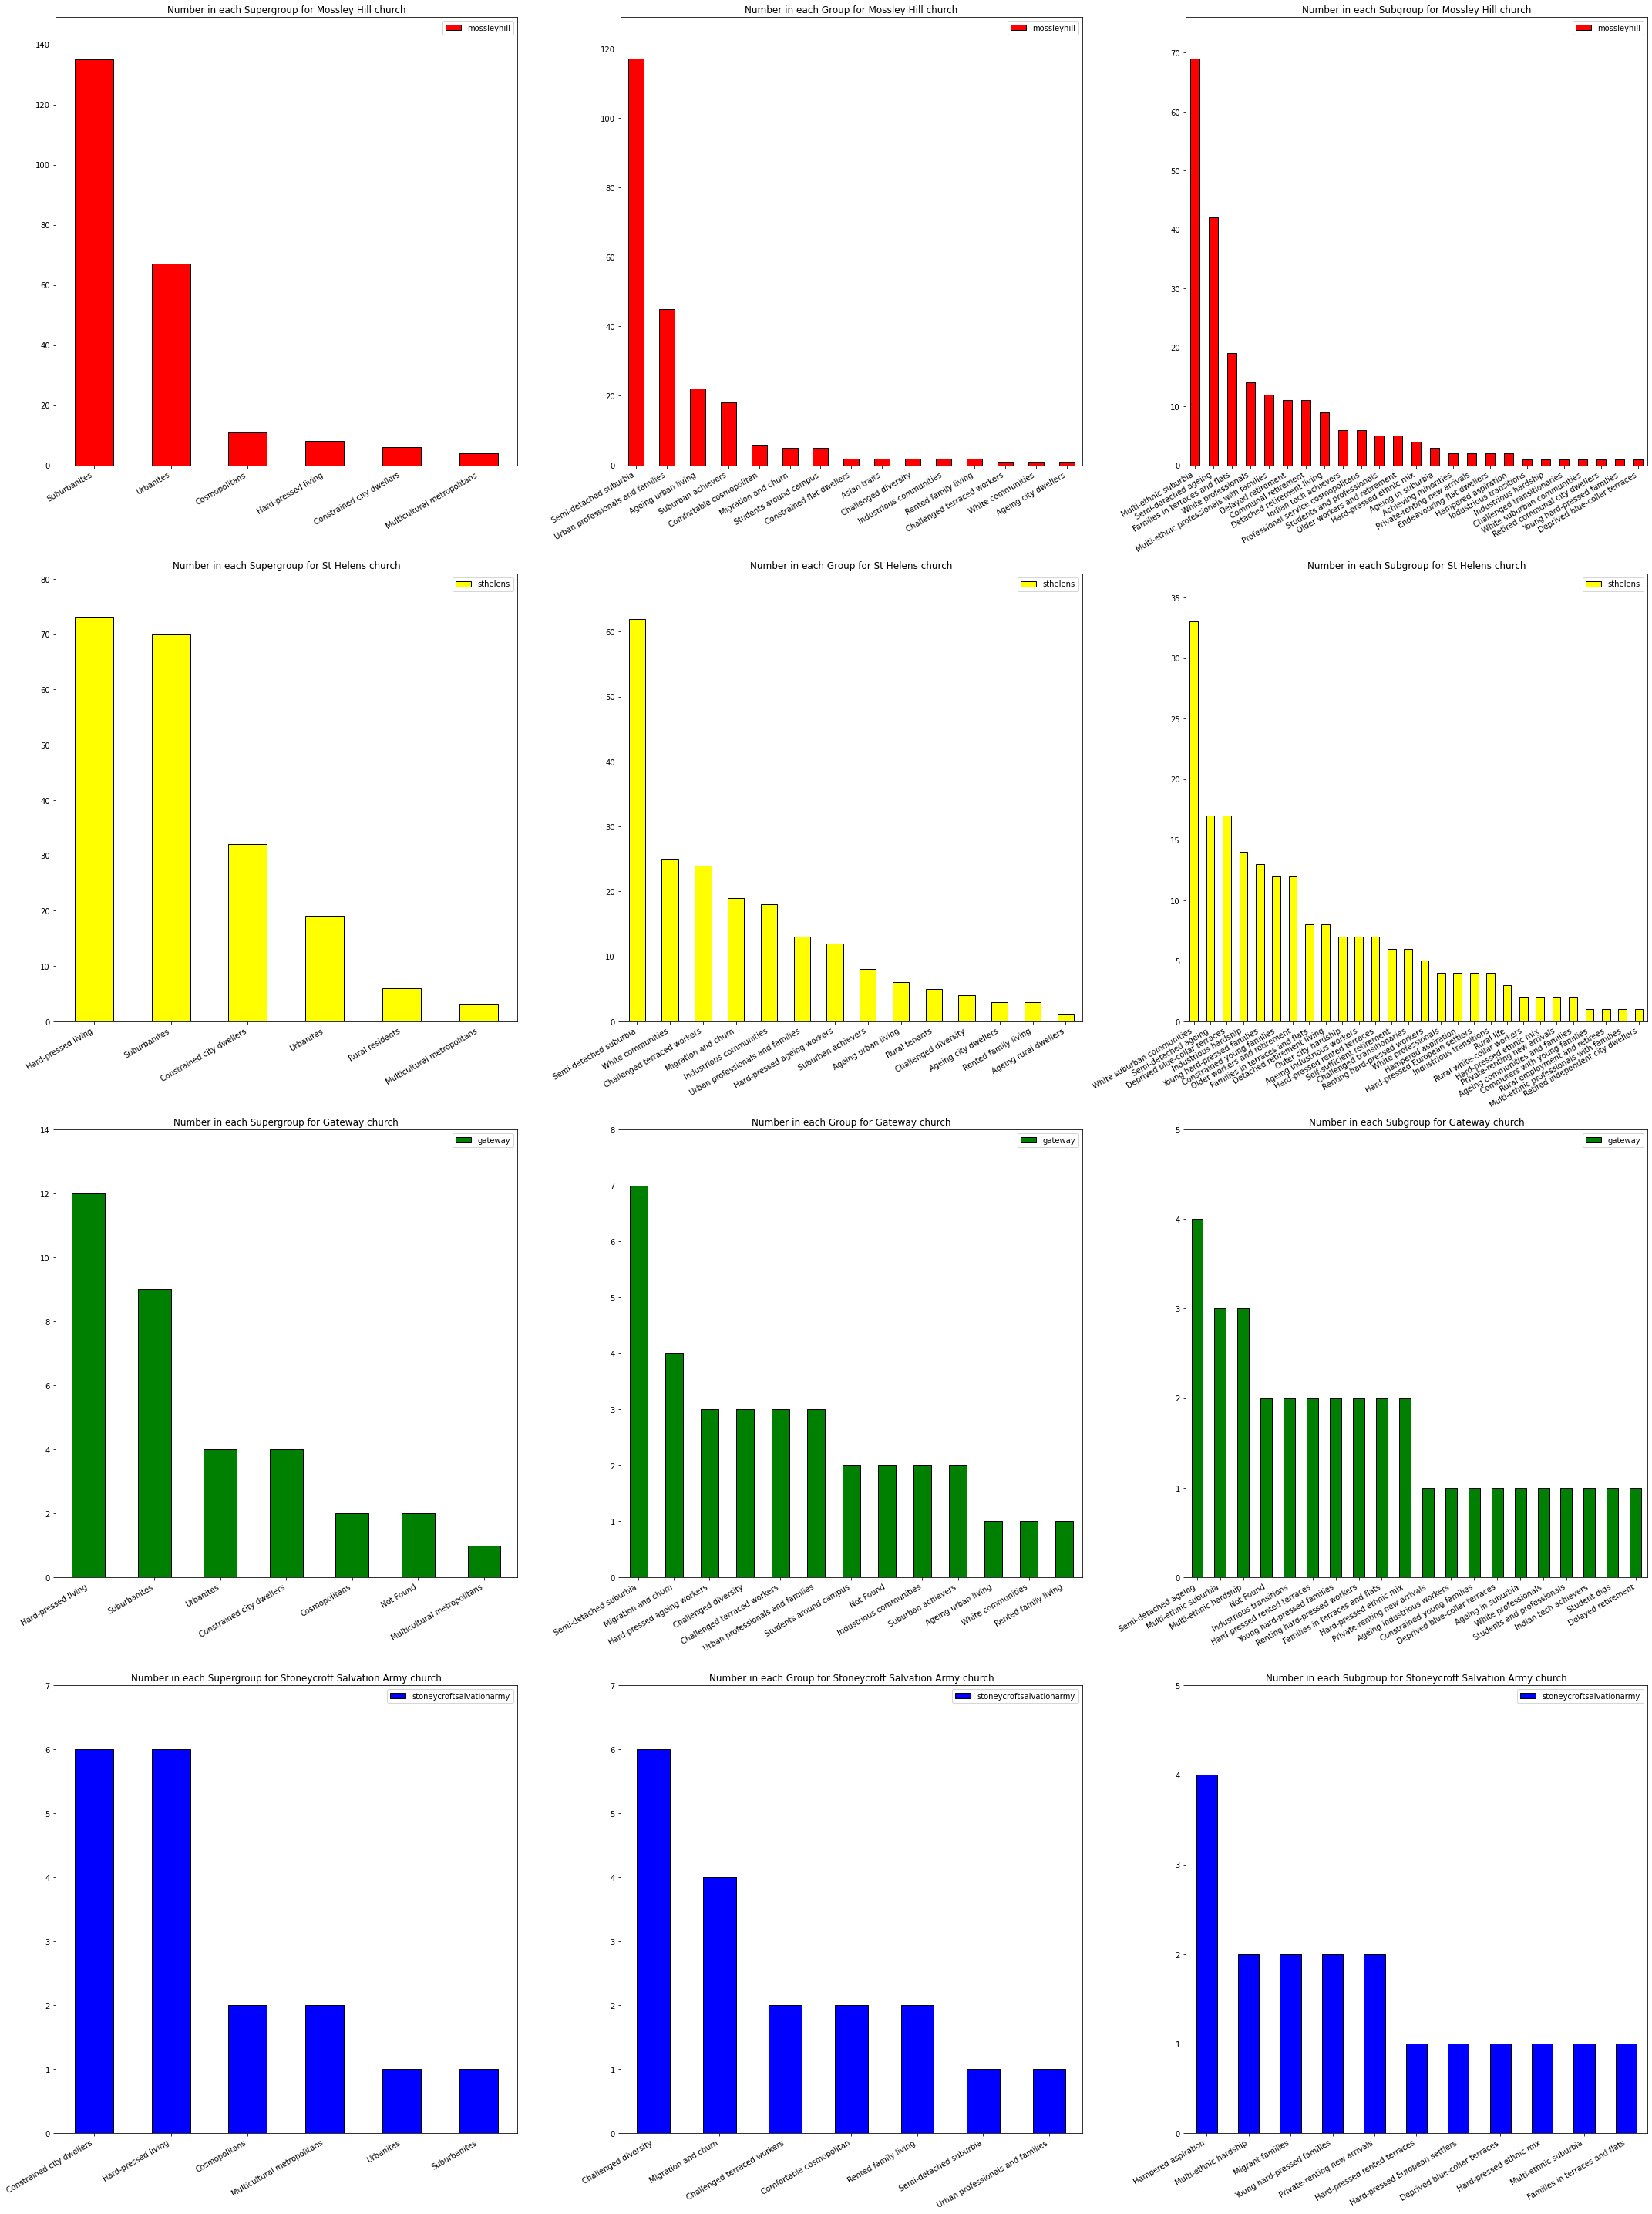

In [7]:
fig, axs = plt.subplots(4,3,figsize=(30,40))

colors = ['red','yellow','green','blue']
precision = ['Supergroup','Group','Subgroup']
church_name = ['Mossley Hill', 'St Helens', 'Gateway', 'Stoneycroft Salvation Army']

for i, church in enumerate(churches):
    for j, p in enumerate(precision):
        ax = axs[i][j]
        data[church][p].value_counts().plot.bar(ax=ax, label=church, color=colors[i], edgecolor='black')
        ax.set_title(f'Number in each {p} for {church_name[i]} church')
        ax.set_ylim(0,int(data[church][p].value_counts()[0]*1.1 + 1))
        ax.legend()
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_ha('right')

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
for church in churches:
    data[church].to_csv(f'sensitive/derived/{church}.csv',index=False)
    

## Visualizing Maps

In [9]:
lcr = gpd.read_file('LiverpoolCityRegion.geojson')
lcr['Supergroup'] = lcr['Subgroup Code'].str[0]
lcr['Classification'] = lcr['Supergroup'].apply(lambda supergroup: portraits.loc[portraits.Code==supergroup].Name.values[0])

In [10]:
dfs = []
for church in churches:
    data[church]['Church'] = church
    dfs.append(data[church])
chu_df = pd.concat(dfs)
lcr_churches = pd.merge(lcr,chu_df,on='OA11CD',how='outer')

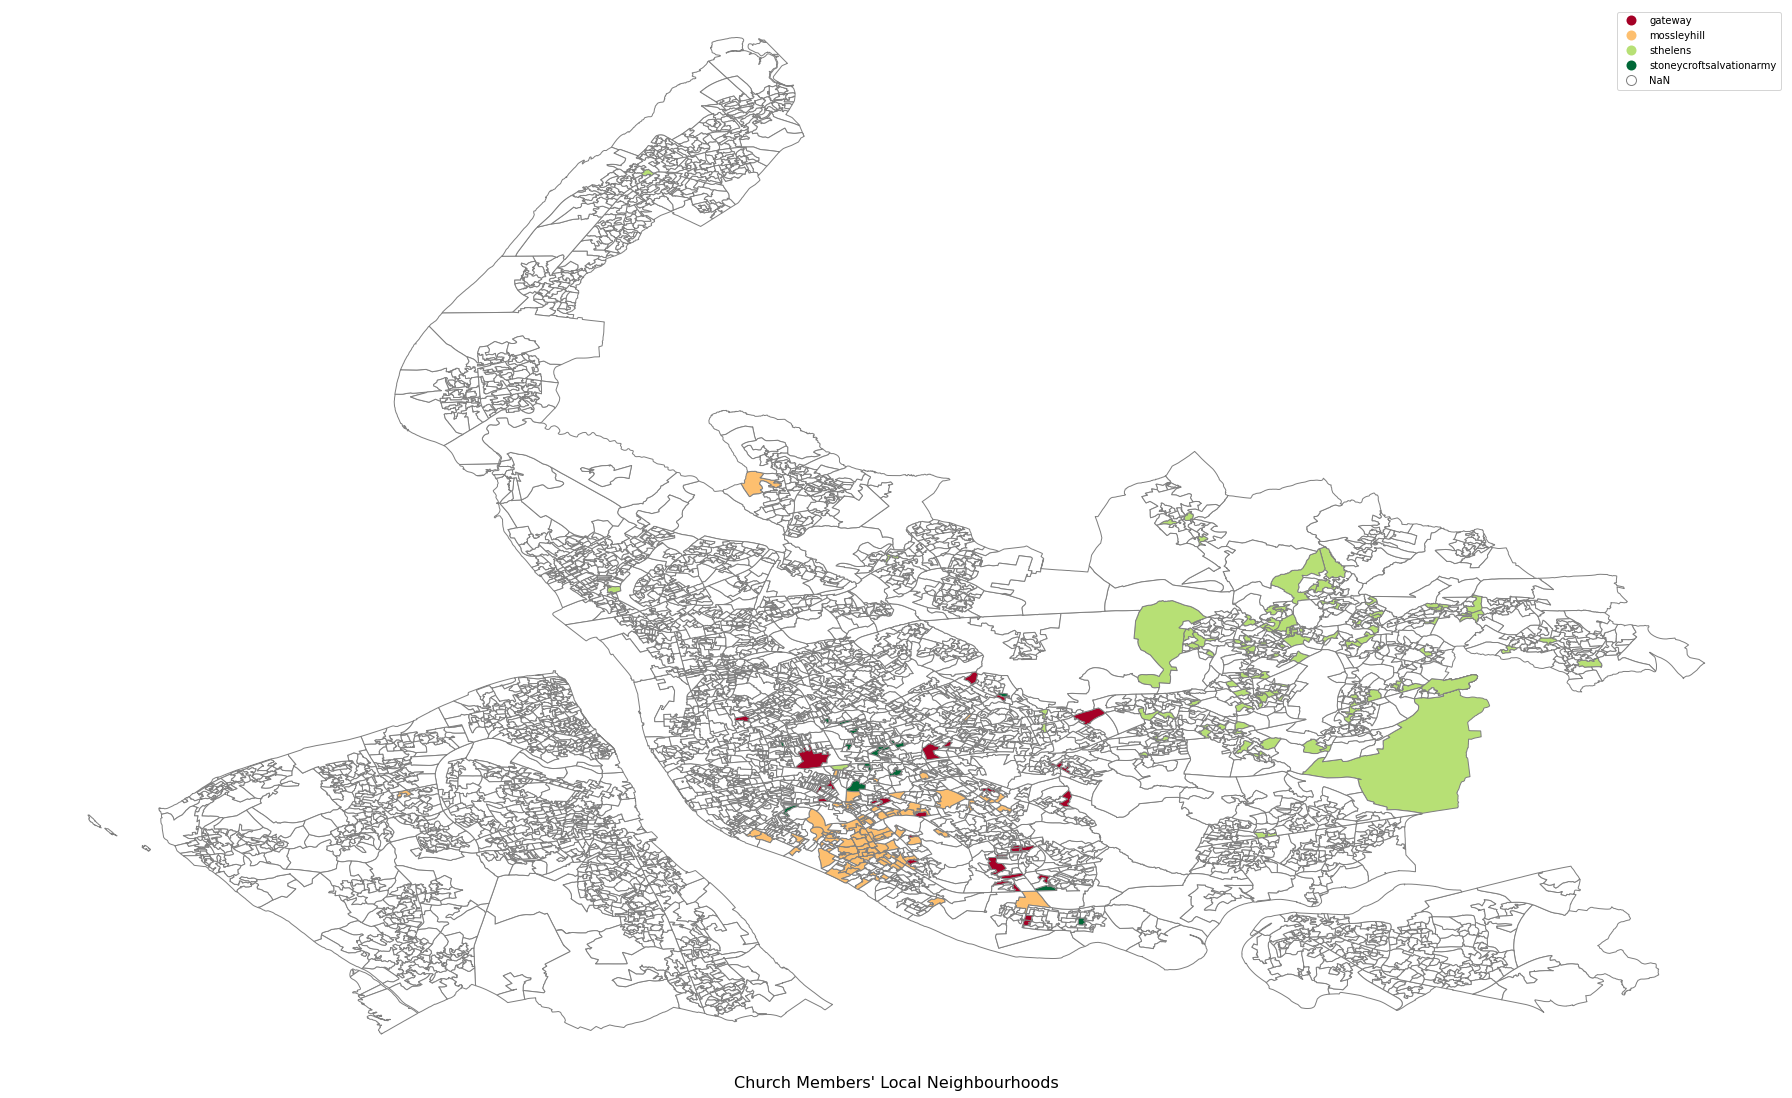

In [11]:
f, ax = plt.subplots(figsize=(25,15))
lcr_churches.plot(column='Church',cmap='RdYlGn',edgecolor='grey',
                        missing_kwds={'color': 'white',
                                  'edgecolor':'grey'},
                  legend=True,
                  ax=ax
                 )
ax.set_axis_off()
f.tight_layout()
f.suptitle('Church Members\' Local Neighbourhoods',
          fontsize=16, y = 0)
plt.axis('equal')
plt.show()

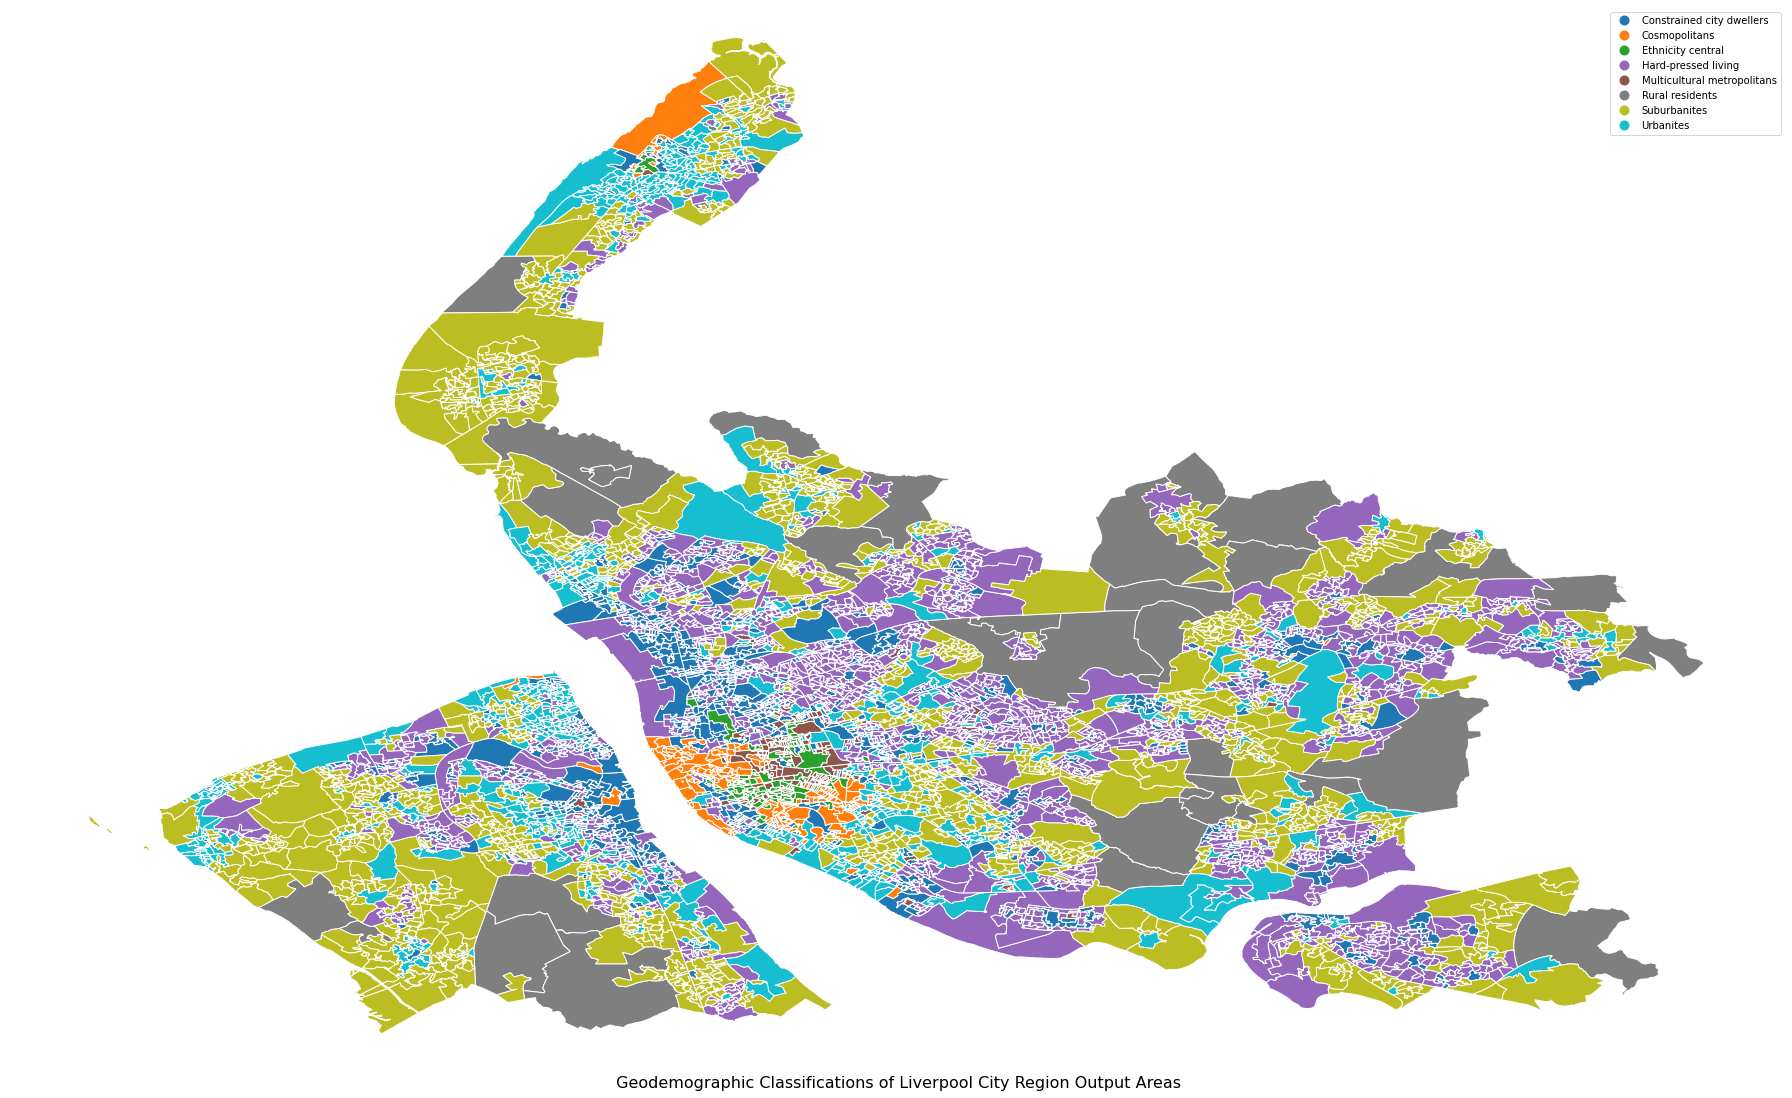

In [12]:
f, ax = plt.subplots(figsize=(25,15))
lcr.plot(column='Classification',edgecolor='white',figsize=(25,25),legend=True, cmap='tab10', ax=ax)
ax.set_axis_off()
f.tight_layout()
f.suptitle(' Geodemographic Classifications of Liverpool City Region Output Areas',
                     fontsize=16, y = 0)
plt.axis('equal')
plt.show()